In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0-rc1

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras import Model
from keras.callbacks import EarlyStopping 
from collections import defaultdict
from tqdm import trange

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13681966231990707314
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15169481714334938317
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10482272550712966090
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330115994
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13860852097862083298
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]


In [25]:
#  load cifar 10 dataset

cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train/255.0, x_test/255.0

print("Train Shape: {0}".format(x_train.shape))
print("Test Shape: {0}".format(x_test.shape))

Train Shape: (50000, 32, 32, 3)
Test Shape: (10000, 32, 32, 3)


In [0]:
# convert number to label

num2label = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer", 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

Answer Label: automobile
(32, 32, 3)


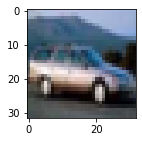

In [27]:
# check dataset

print("Answer Label: {0}".format(num2label[y_train[4][0]]))
print(x_train[4].shape)
plt.figure(figsize=(2, 2))
plt.imshow(x_train[4])

## MC Dropout

In [0]:
class BayesianModel(Model):
    def __init__(self):
        super(BayesianModel, self).__init__()
        self.conv1 = Conv2D(64, (3, 3), activation="relu")
        self.dropout1 = Dropout(0.5)
        self.pool1 = MaxPool2D()
        # second layer
        self.conv2 = Conv2D(128, (3, 3), activation="relu")
        self.dropout2 = Dropout(0.5)
        self.pool2 = MaxPool2D()
        # third layer
        self.conv3 = Conv2D(256, (3, 3), activation="relu")
        self.dropout3 = Dropout(0.5)
        self.pool3 = GlobalAveragePooling2D()
        self.flatten = Flatten()
        # fourth layer
        self.dense1 = Dense(1024, activation="relu")
        self.dropout4 = Dropout(0.5)
        # output
        self.dense2 = Dense(10, activation="softmax") 

    def call(self, x):
        x = self.conv1(x)
        x = self.dropout1(x, training=True)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.dropout2(x, training=True)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.dropout3(x, training=True)
        x = self.pool3(x)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dropout4(x, training=True)
        y = self.dense2(x)

        return y


model = BayesianModel()

In [0]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(buffer_size=1024).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name = 'train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'train_accuracy')

test_loss = tf.keras.metrics.Mean(name = 'test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = 'test_accuracy')

In [0]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  train_loss(loss)
  train_accuracy(labels, predictions)

In [0]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)

In [15]:
epochs = 10

for epoch in range(epochs):
  for images, labels in train_ds:
    train_step(images, labels)

  for test_images, test_labels in test_ds:
    test_step(test_images, test_labels)

  template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
  print (template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))
  
  # 次のエポック用にメトリクスをリセット
  train_loss.reset_states()
  train_accuracy.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1, Loss: 1.6396541595458984, Accuracy: 38.555999755859375, Test Loss: 1.3648489713668823, Test Accuracy: 50.13999938964844
Epoch 2, Loss: 1.28488028049469, Accuracy: 53.772003173828125, Test Loss: 1.2197985649108887, Test Accuracy: 56.540000915527344
Epoch 3, Loss: 1.1293367147445679, Accuracy: 60.012001037597656, Test Loss: 1.0849616527557373, Test Accuracy: 61.33000183105469
Epoch 4, Loss: 1.0418016910552979, Accuracy: 63.336002349853516, Test Loss: 1.0218963623046875, Test Accuracy: 64.25
Epoch

## Predict by MC Dropout

In [0]:
def mc_dropout_prediction(x_test, y_test, sample_num=50, class_num=10):
  pred_dctlst = {"answer": [], "entropy": []}
  for i in trange(len(x_test)):
    image = x_test[i]
    image = image[np.newaxis]
    preds = np.zeros((sample_num, class_num), dtype=np.float32)
    for j in range(sample_num):
      predictions = model(image)
      preds[j, :] = predictions
    preds = preds.mean(axis=0)
    entropy = np.sum(-preds*np.log(preds))
    pred_dctlst["answer"].append(y_test[i][0])
    pred_dctlst["entropy"].append(entropy)

  return pred_dctlst

In [87]:
pred_dctlst = mc_dropout_prediction(x_test, y_test)
pred_df = pd.DataFrame(pred_dctlst).sort_values("entropy", ascending=True)
pred_df.head()

100%|██████████| 1000/1000 [08:24<00:00,  1.90it/s]


## Visualization high/low entropy image

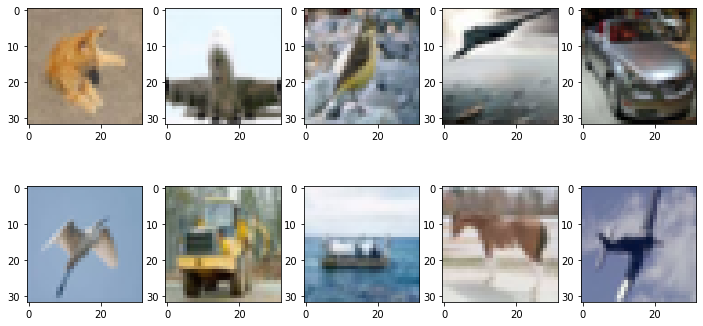

In [89]:
target_class = 0
ex_num = 10
min_idx_lst = list(pred_df[pred_df["answer"] == target_class].index)[:ex_num]
max_idx_lst = list(pred_df[pred_df["answer"] == target_class].index)[-ex_num:]

plt.figure(figsize=(12, 6))

for i, idx in enumerate(min_idx_lst):
  image = x_test[idx]
  plt.subplot(2, 5, i+1)
  plt.imshow(image)